In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

# 행 출력 제한 없애기
pd.set_option('display.max_rows', None)
# 열 출력 제한 없애기
pd.set_option('display.max_columns', None)


print("라이브러리 로드 완료")

라이브러리 로드 완료


## 1. 전처리된 데이터 확인

In [41]:
# 데이터 경로
processed_dir = Path('../data/processed')
models_dir = Path('../data/models')
results_dir = Path('../data/vaep_results')

# 파일 존재 확인
files_to_check = {
    '학습 데이터': processed_dir / 'vaep_train_events.csv',
    '평가 데이터': processed_dir / 'vaep_eval_events_england.csv',
    '모델 파일': models_dir / 'vaep_model.pt',
    '모델 설정': models_dir / 'vaep_config.json',
    '경기별 VAEP': results_dir / 'player_match_vaep_england.csv',
    '시즌별 VAEP': results_dir / 'player_season_vaep_england.csv'
}

print("=" * 60)
print("파일 존재 확인")
print("=" * 60)
for name, path in files_to_check.items():
    exists = "✓" if path.exists() else "✗"
    size = f"{path.stat().st_size / 1024:.1f} KB" if path.exists() else "N/A"
    print(f"{exists} {name:20s}: {size:>10s}")
print()

파일 존재 확인
✓ 학습 데이터              :  8894.7 KB
✓ 평가 데이터              :  1484.3 KB
✓ 모델 파일               :    89.5 KB
✓ 모델 설정               :     1.8 KB
✓ 경기별 VAEP            :     9.3 KB
✓ 시즌별 VAEP            :    10.0 KB



In [42]:
# 학습 데이터 로드
train_df = pd.read_csv(processed_dir / 'vaep_train_events.csv')

print("=" * 60)
print("학습 데이터 기본 정보")
print("=" * 60)
print(f"총 이벤트 수: {len(train_df):,}")
print(f"컬럼 수: {len(train_df.columns)}")
print(f"매치 수: {train_df['matchId'].nunique():,}")
print(f"선수 수: {train_df['playerId'].nunique():,}")
print(f"리그: {train_df['league'].unique().tolist()}")
print()

print("컬럼 목록:")
print(train_df.columns.tolist())
print()

train_df.head()

학습 데이터 기본 정보
총 이벤트 수: 47,964
컬럼 수: 22
매치 수: 30
선수 수: 673
리그: ['European_Championship', 'World_Cup', 'France', 'Germany', 'Spain', 'Italy']

컬럼 목록:
['id', 'matchId', 'playerId', 'teamId', 'league', 'eventId', 'eventName', 'subEventId', 'subEventName', 'period', 'event_sec', 'start_x', 'start_y', 'end_x', 'end_y', 'distance', 'angle', 'goal_distance', 'goal_angle', 'is_goal', 'is_successful', 'tags_list']



,id,matchId,playerId,teamId,league,eventId,eventName,subEventId,subEventName,period,event_sec,start_x,start_y,end_x,end_y,distance,angle,goal_distance,goal_angle,is_goal,is_successful,tags_list
0,88178642,1694390,26010,4418,European_Championship,8,Pass,85.0,Simple pass,1,1.255990,0.50,0.48,0.47,0.50,0.036056,2.553590,0.500400,0.214132,0,1,[1801]
1,88178643,1694390,3682,4418,European_Championship,8,Pass,85.0,Simple pass,1,2.351908,0.47,0.50,0.41,0.48,0.063246,-2.819842,0.530000,0.202414,0,1,[1801]
2,88178644,1694390,31528,4418,European_Championship,8,Pass,85.0,Simple pass,1,3.241028,0.41,0.48,0.32,0.35,0.158114,-2.176341,0.590339,0.181743,0,1,[1801]
3,88178645,1694390,7855,4418,European_Championship,8,Pass,83.0,High pass,1,6.033681,0.32,0.35,0.89,0.06,0.639531,-0.470641,0.696348,0.150715,0,0,[1802]
4,88178646,1694390,25437,4418,European_Championship,1,Duel,12.0,Ground defending duel,1,13.143591,0.89,0.06,0.85,0.00,0.072111,-2.158799,0.453542,0.058321,0,1,"[702, 1801]"


In [43]:
# 평가 데이터 로드
eval_df = pd.read_csv(processed_dir / 'vaep_eval_events_england.csv')

print("=" * 60)
print("평가 데이터 (England) 기본 정보")
print("=" * 60)
print(f"총 이벤트 수: {len(eval_df):,}")
print(f"매치 수: {eval_df['matchId'].nunique():,}")
print(f"선수 수: {eval_df['playerId'].nunique():,}")
print()

eval_df.head()

평가 데이터 (England) 기본 정보
총 이벤트 수: 8,101
매치 수: 5
선수 수: 137



,id,matchId,playerId,teamId,league,eventId,eventName,subEventId,subEventName,period,event_sec,start_x,start_y,end_x,end_y,distance,angle,goal_distance,goal_angle,is_goal,is_successful,tags_list
0,177959171,2499719,25413,1609,England,8,Pass,85.0,Simple pass,1,2.758649,0.49,0.49,0.31,0.78,0.341321,2.126290,0.510098,0.210215,0,1,[1801]
1,177959172,2499719,370224,1609,England,8,Pass,83.0,High pass,1,4.946850,0.31,0.78,0.51,0.75,0.202237,-0.148890,0.744648,0.133851,0,1,[1801]
2,177959173,2499719,3319,1609,England,8,Pass,82.0,Head pass,1,6.542188,0.51,0.75,0.35,0.71,0.164924,-2.896614,0.550091,0.174214,0,1,[1801]
3,177959174,2499719,120339,1609,England,8,Pass,82.0,Head pass,1,8.143395,0.35,0.71,0.41,0.95,0.247386,1.325818,0.683081,0.149765,0,1,[1801]
4,177959175,2499719,167145,1609,England,8,Pass,85.0,Simple pass,1,10.302366,0.41,0.95,0.72,0.88,0.317805,-0.222082,0.742024,0.115445,0,1,[1801]


In [44]:
# 데이터 통계
print("=" * 60)
print("학습 데이터 통계")
print("=" * 60)
train_df.shape

학습 데이터 통계


(47964, 22)

## 2. 피처 인코딩 확인

이벤트 타입 분포 (학습 데이터)
eventId  eventName              
8        Pass                       25921
1        Duel                       12341
7        Others on the ball          3579
3        Free Kick                   2869
5        Interruption                1325
2        Foul                         793
10       Shot                         638
9        Save attempt                 246
6        Offside                      136
4        Goalkeeper leaving line      116
dtype: int64

고유 이벤트 타입 수: 10



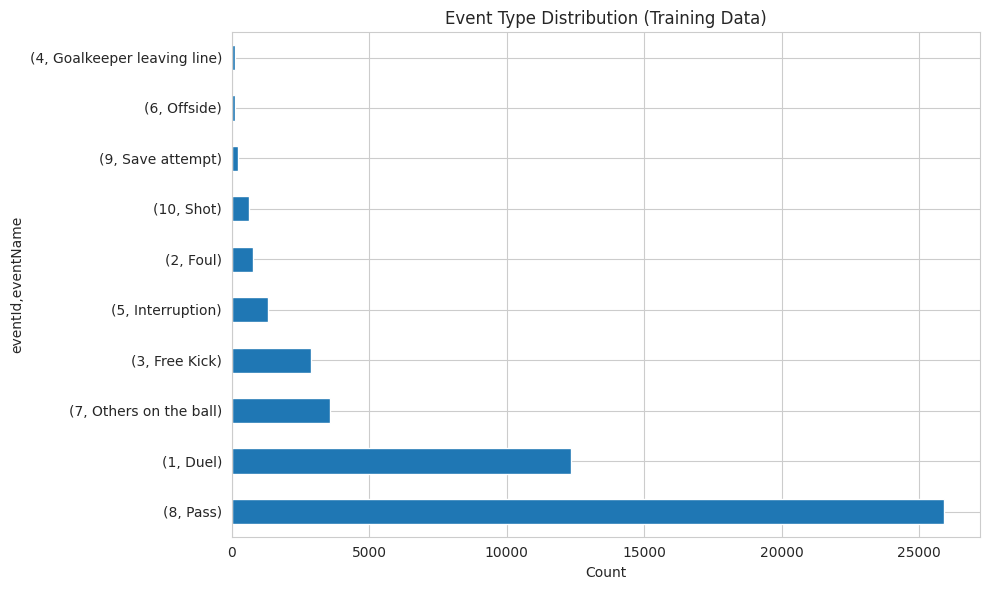

In [45]:
# 이벤트 타입 분포
print("=" * 60)
print("이벤트 타입 분포 (학습 데이터)")
print("=" * 60)
event_counts = train_df.groupby(['eventId', 'eventName']).size().sort_values(ascending=False)
print(event_counts)
print(f"\n고유 이벤트 타입 수: {train_df['eventId'].nunique()}")
print()

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
event_counts.plot(kind='barh', ax=ax)
ax.set_xlabel('Count')
ax.set_title('Event Type Distribution (Training Data)')
plt.tight_layout()
plt.show()

서브이벤트 타입 분포 (TOP 20)
subEventId  subEventName          
85.0        Simple pass               20391
11.0        Ground attacking duel      3972
12.0        Ground defending duel      3855
10.0        Air duel                   2378
72.0        Touch                      2348
13.0        Ground loose ball duel     2136
83.0        High pass                  1950
82.0        Head pass                  1453
50.0        Ball out of the field      1315
36.0        Throw in                   1249
80.0        Cross                       893
71.0        Clearance                   843
20.0        Foul                        746
31.0        Free Kick                   665
100.0       Shot                        638
84.0        Launch                      596
34.0        Goal kick                   492
86.0        Smart pass                  445
70.0        Acceleration                388
30.0        Corner                      283
dtype: int64

고유 서브이벤트 타입 수: 35



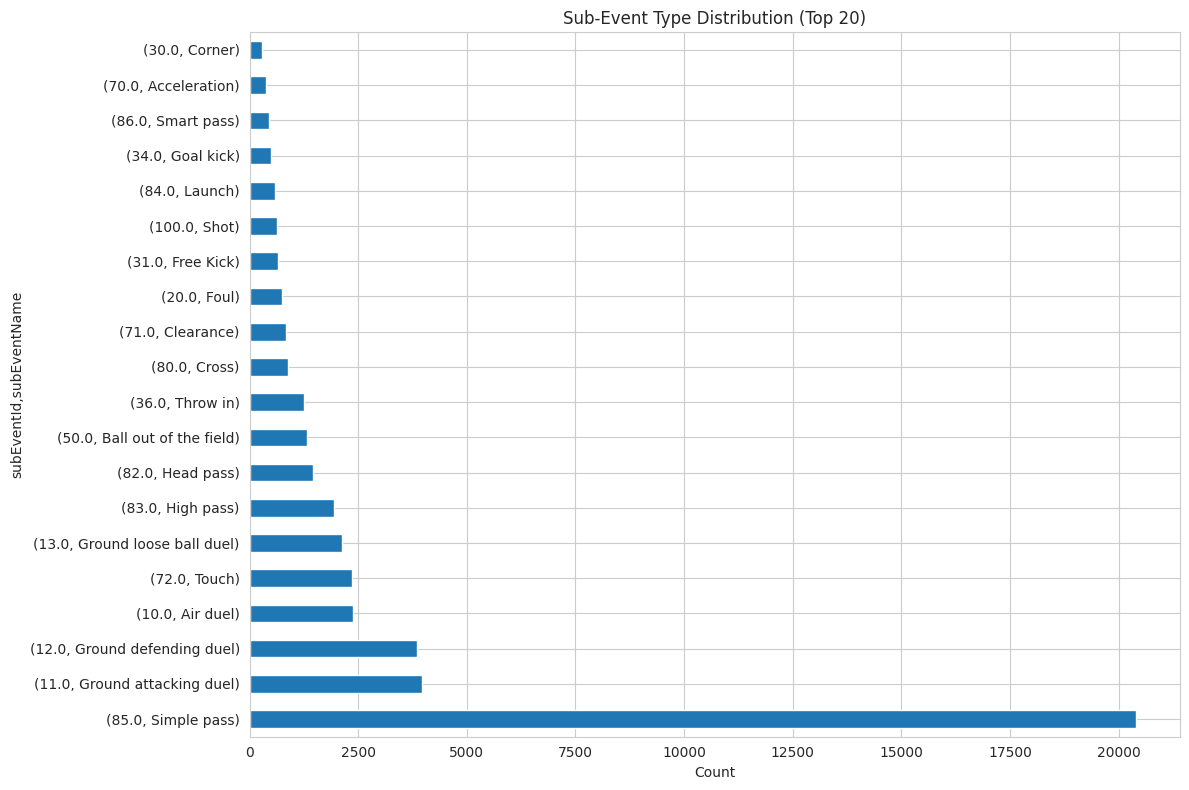

In [46]:
# 서브이벤트 타입 분포
print("=" * 60)
print("서브이벤트 타입 분포 (TOP 20)")
print("=" * 60)
subevent_counts = train_df.groupby(['subEventId', 'subEventName']).size().sort_values(ascending=False).head(20)
print(subevent_counts)
print(f"\n고유 서브이벤트 타입 수: {train_df['subEventId'].nunique()}")
print()

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
subevent_counts.plot(kind='barh', ax=ax)
ax.set_xlabel('Count')
ax.set_title('Sub-Event Type Distribution (Top 20)')
plt.tight_layout()
plt.show()

태그 분포 분석
고유 태그 수: 57
총 태그 발생 횟수: 67,740

TOP 20 태그:
1801    32244
1802    10485
703      4815
701      4779
702      2747
1401     2527
402       889
502       856
801       846
501       843
1901      817
504       773
503       769
401       586
201       466
901       402
1601      328
2101      310
602       288
601       265
Name: count, dtype: int64



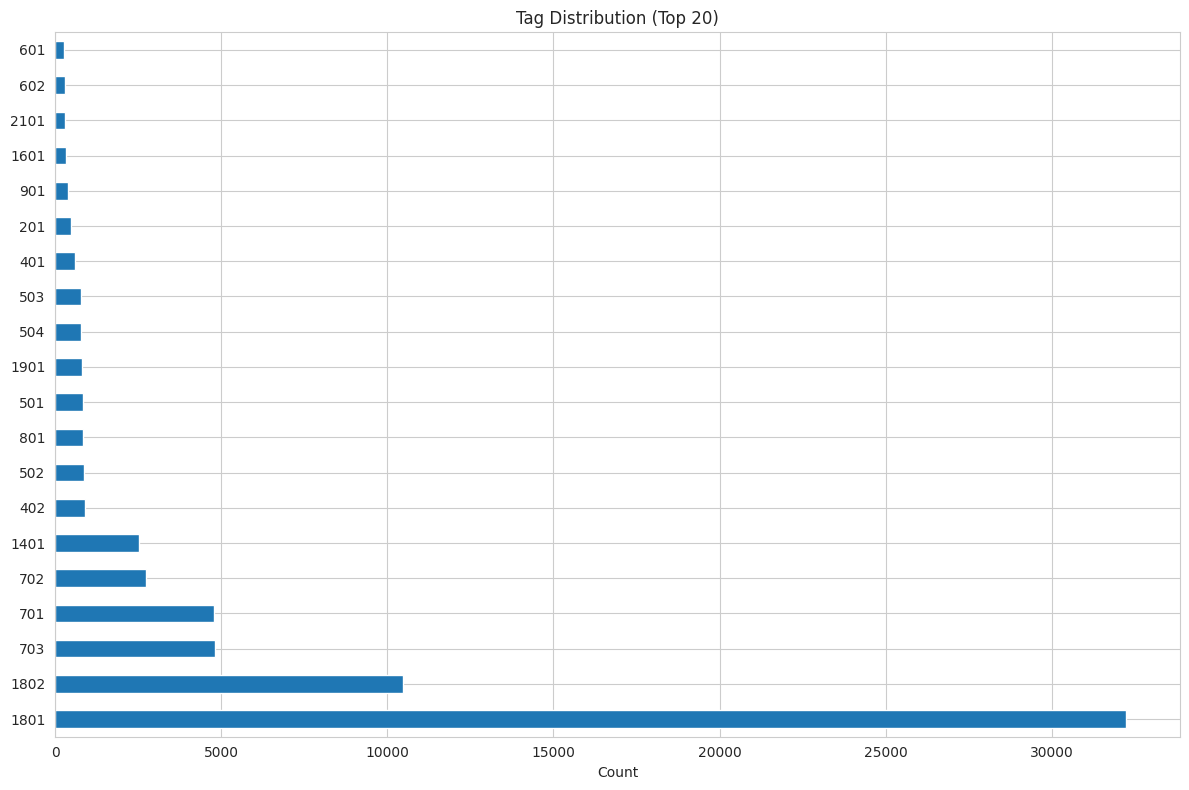

In [47]:
# 태그 분포 확인
print("=" * 60)
print("태그 분포 분석")
print("=" * 60)

# tags_list를 JSON에서 파싱
def parse_tags(tags_str):
    try:
        return json.loads(tags_str) if isinstance(tags_str, str) else []
    except:
        return []

train_df['tags_parsed'] = train_df['tags_list'].apply(parse_tags)

# 모든 태그 수집
all_tags = []
for tags in train_df['tags_parsed']:
    all_tags.extend(tags)

tag_counts = pd.Series(all_tags).value_counts().head(20)
print(f"고유 태그 수: {len(pd.Series(all_tags).unique())}")
print(f"총 태그 발생 횟수: {len(all_tags):,}")
print(f"\nTOP 20 태그:")
print(tag_counts)
print()

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
tag_counts.plot(kind='barh', ax=ax)
ax.set_xlabel('Count')
ax.set_title('Tag Distribution (Top 20)')
plt.tight_layout()
plt.show()

In [48]:
# 지정된 태그 ID 사용 확인
EXPECTED_TAG_IDS = [101, 102, 201, 301, 302, 403, 501, 502, 503, 504, 601, 602, 701, 702, 703, 
                     801, 802, 901, 1101, 1102, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 
                     1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 
                     1221, 1222, 1223, 1301, 1302, 1401, 1501, 1601, 1701, 1702, 1703, 1801, 
                     1802, 2001, 2101]

unique_tags = pd.Series(all_tags).unique()
used_expected_tags = [tag for tag in EXPECTED_TAG_IDS if tag in unique_tags]
unused_expected_tags = [tag for tag in EXPECTED_TAG_IDS if tag not in unique_tags]

print("=" * 60)
print("지정된 태그 사용 현황")
print("=" * 60)
print(f"지정된 태그 수: {len(EXPECTED_TAG_IDS)}")
print(f"실제 사용된 지정 태그 수: {len(used_expected_tags)}")
print(f"사용되지 않은 지정 태그 수: {len(unused_expected_tags)}")
if unused_expected_tags:
    print(f"\n사용되지 않은 태그 ID: {unused_expected_tags}")
print()

지정된 태그 사용 현황
지정된 태그 수: 55
실제 사용된 지정 태그 수: 53
사용되지 않은 지정 태그 수: 2

사용되지 않은 태그 ID: [802, 1501]



## 3. 모델 설정 확인

In [49]:
# 모델 설정 로드
with open(models_dir / 'vaep_config.json', 'r') as f:
    model_config = json.load(f)

print("=" * 60)
print("모델 설정")
print("=" * 60)
print(f"입력 차원: {model_config['input_dim']}")
print(f"은닉층 차원: {model_config['hidden_dims']}")
print(f"Horizon: {model_config['horizon']}")
print(f"Best Validation Loss: {model_config['best_val_loss']:.6f}")
print(f"\n총 피처 수: {len(model_config['feature_names'])}")
print()

모델 설정
입력 차원: 105
은닉층 차원: [128, 64]
Horizon: 10
Best Validation Loss: 0.166987

총 피처 수: 105



피처 그룹별 개수
이벤트 타입: 10
서브이벤트 타입: 29
태그: 55
위치: 4
골 관련: 2
이동: 2
성공 여부: 1
피리어드: 2

총합: 105



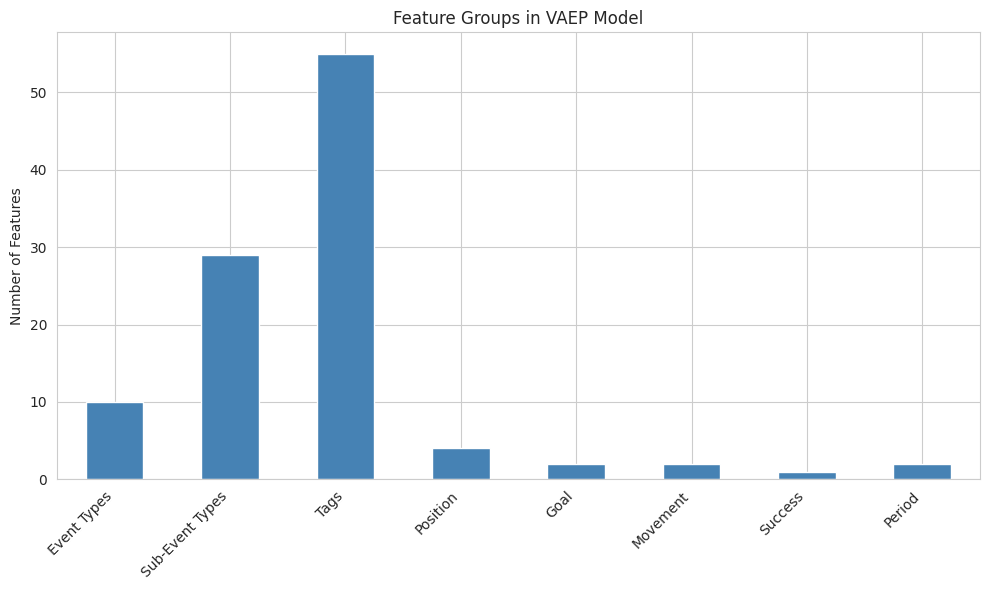

In [50]:
# 피처 그룹별 분석
feature_names = model_config['feature_names']

event_features = [f for f in feature_names if f.startswith('event_')]
subevent_features = [f for f in feature_names if f.startswith('subevent_')]
tag_features = [f for f in feature_names if f.startswith('tag_')]
position_features = ['start_x', 'start_y', 'end_x', 'end_y']
goal_features = ['goal_distance', 'goal_angle']
movement_features = ['distance', 'angle']
success_features = ['is_successful']
period_features = [f for f in feature_names if f.startswith('period_')]

print("=" * 60)
print("피처 그룹별 개수")
print("=" * 60)
print(f"이벤트 타입: {len(event_features)}")
print(f"서브이벤트 타입: {len(subevent_features)}")
print(f"태그: {len(tag_features)}")
print(f"위치: {len(position_features)}")
print(f"골 관련: {len(goal_features)}")
print(f"이동: {len(movement_features)}")
print(f"성공 여부: {len(success_features)}")
print(f"피리어드: {len(period_features)}")
print(f"\n총합: {len(event_features) + len(subevent_features) + len(tag_features) + len(position_features) + len(goal_features) + len(movement_features) + len(success_features) + len(period_features)}")
print()

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
feature_groups = {
    'Event Types': len(event_features),
    'Sub-Event Types': len(subevent_features),
    'Tags': len(tag_features),
    'Position': len(position_features),
    'Goal': len(goal_features),
    'Movement': len(movement_features),
    'Success': len(success_features),
    'Period': len(period_features)
}
pd.Series(feature_groups).plot(kind='bar', ax=ax, color='steelblue')
ax.set_ylabel('Number of Features')
ax.set_title('Feature Groups in VAEP Model')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [51]:
# 사용된 태그 피처 상세
print("=" * 60)
print(f"태그 피처 목록 ({len(tag_features)}개)")
print("=" * 60)
for i, tag in enumerate(tag_features, 1):
    if i % 5 == 0:
        print(tag)
    else:
        print(tag, end='  ')
print("\n")

태그 피처 목록 (55개)
tag_101  tag_102  tag_201  tag_301  tag_302
tag_403  tag_501  tag_502  tag_503  tag_504
tag_601  tag_602  tag_701  tag_702  tag_703
tag_801  tag_802  tag_901  tag_1101  tag_1102
tag_1201  tag_1202  tag_1203  tag_1204  tag_1205
tag_1206  tag_1207  tag_1208  tag_1209  tag_1210
tag_1211  tag_1212  tag_1213  tag_1214  tag_1215
tag_1216  tag_1217  tag_1218  tag_1219  tag_1220
tag_1221  tag_1222  tag_1223  tag_1301  tag_1302
tag_1401  tag_1501  tag_1601  tag_1701  tag_1702
tag_1703  tag_1801  tag_1802  tag_2001  tag_2101




## 태그 인코딩 검증

태그는 `tag_101`, `tag_102` 등으로 인코딩되어 학습에 사용됩니다. 이것은:
- **정상적인 원핫/멀티핫 인코딩 방식**입니다
- 실제 태그 ID(101, 102 등)가 **피처명**으로 사용되며
- 모델은 이 **이진 피처**(0 또는 1)를 학습합니다
- 태그 ID 자체가 아닌 **인코딩된 이진 벡터**를 사용하므로 올바른 방식입니다

예: 이벤트에 태그 [101, 301]이 있으면
- tag_101 = 1, tag_102 = 0, ..., tag_301 = 1, ... 형태로 변환
- 모델은 55차원의 이진 벡터를 입력받음


## 4. 선수 VAEP 결과 분석

In [52]:
# 경기별 VAEP 로드
player_match_vaep = pd.read_csv(results_dir / 'player_match_vaep_england.csv')

print("=" * 60)
print("경기별 VAEP 데이터")
print("=" * 60)
print(f"총 레코드 수: {len(player_match_vaep):,}")
print(f"고유 선수 수: {player_match_vaep['playerId'].nunique()}")
print(f"고유 매치 수: {player_match_vaep['matchId'].nunique()}")
print()

print("컬럼:")
print(player_match_vaep.columns.tolist())
print()

player_match_vaep.head(10)

경기별 VAEP 데이터
총 레코드 수: 136
고유 선수 수: 127
고유 매치 수: 5

컬럼:
['playerId', 'matchId', 'teamId', 'vaep', 'num_events', 'minutes_played', 'vaep_per90']



,playerId,matchId,teamId,vaep,num_events,minutes_played,vaep_per90
0,0,2499719,1609,-0.094678,62,90.0,-0.094678
1,0,2499719,1631,-0.020566,102,90.0,-0.020566
2,0,2499720,1625,-0.008015,22,90.0,-0.008015
3,0,2499720,1651,-0.035604,92,90.0,-0.035604
4,0,2499721,1610,-0.023819,29,90.0,-0.023819
5,0,2499721,1646,-0.009585,69,90.0,-0.009585
6,0,2499722,1628,-0.026844,25,90.0,-0.026844
7,0,2499722,1673,-0.021201,121,90.0,-0.021201
8,0,2499723,1623,-0.020739,29,90.0,-0.020739
9,0,2499723,1639,0.005442,104,90.0,0.005442


In [53]:
# VAEP 통계
print("=" * 60)
print("VAEP 통계")
print("=" * 60)
print(player_match_vaep[['vaep', 'vaep_per90', 'num_events', 'minutes_played']].describe())
print()

VAEP 통계
             vaep  vaep_per90  num_events  minutes_played
count  136.000000  136.000000  136.000000      136.000000
mean     0.001001    0.002401   56.720588       80.404412
std      0.028830    0.035590   31.231914       18.499801
min     -0.094678   -0.094678    2.000000       45.000000
25%     -0.015694   -0.016229   32.250000       90.000000
50%     -0.000932   -0.001428   54.000000       90.000000
75%      0.009940    0.012827   77.250000       90.000000
max      0.091061    0.182122  129.000000       90.000000



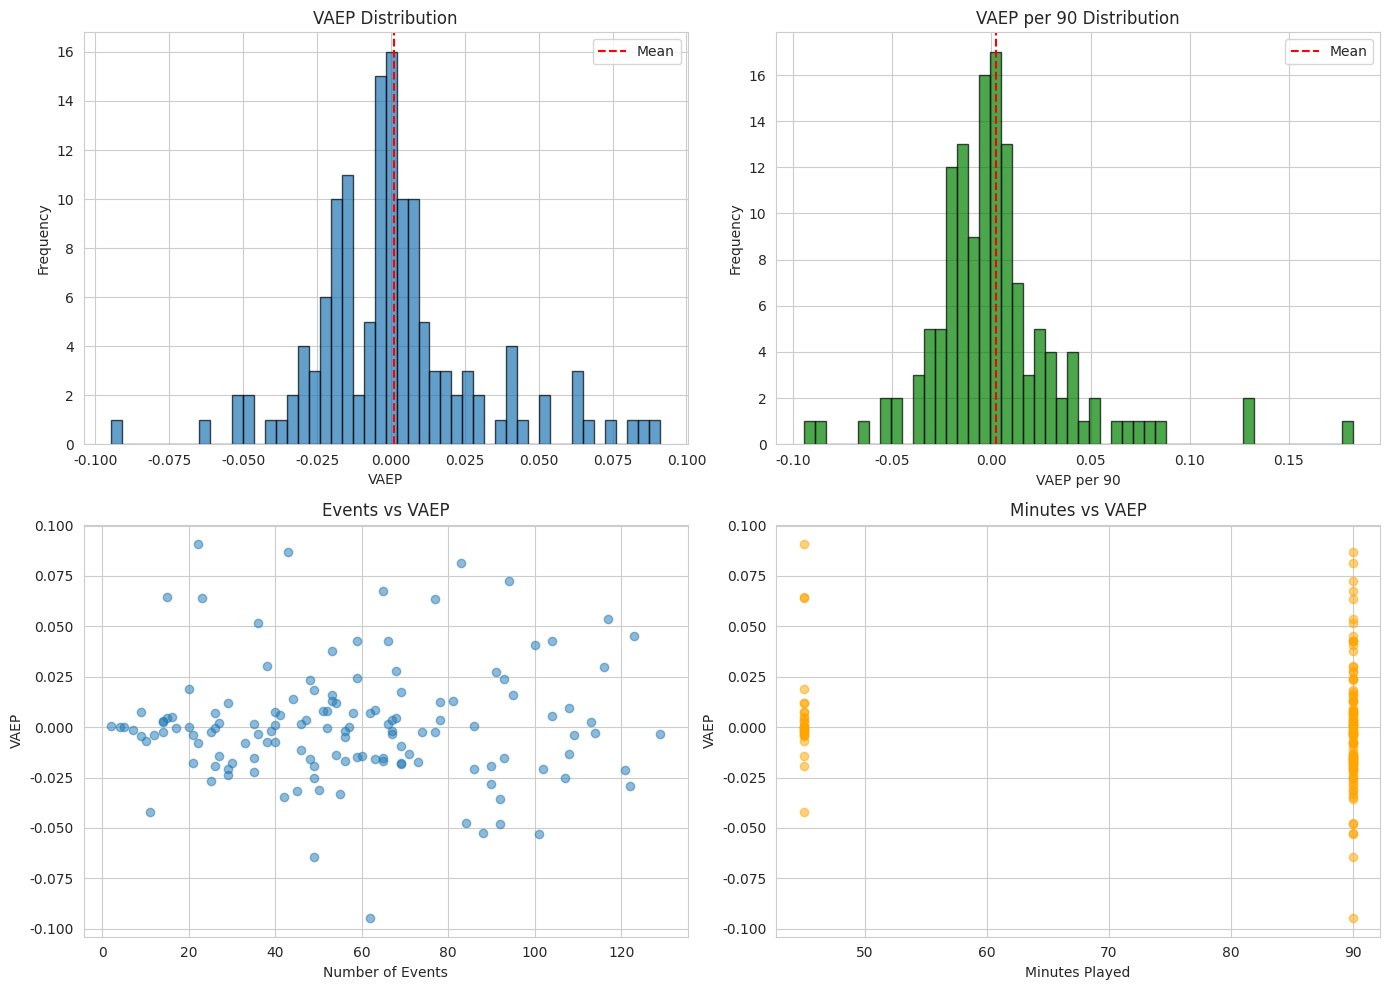

In [65]:
# VAEP 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# VAEP 분포
axes[0, 0].hist(player_match_vaep['vaep'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('VAEP')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('VAEP Distribution')
axes[0, 0].axvline(player_match_vaep['vaep'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# VAEP per 90 분포
axes[0, 1].hist(player_match_vaep['vaep_per90'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('VAEP per 90')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('VAEP per 90 Distribution')
axes[0, 1].axvline(player_match_vaep['vaep_per90'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# 이벤트 수 vs VAEP
axes[1, 0].scatter(player_match_vaep['num_events'], player_match_vaep['vaep'], alpha=0.5)
axes[1, 0].set_xlabel('Number of Events')
axes[1, 0].set_ylabel('VAEP')
axes[1, 0].set_title('Events vs VAEP')

# 출전 시간 vs VAEP
axes[1, 1].scatter(player_match_vaep['minutes_played'], player_match_vaep['vaep'], alpha=0.5, color='orange')
axes[1, 1].set_xlabel('Minutes Played')
axes[1, 1].set_ylabel('VAEP')
axes[1, 1].set_title('Minutes vs VAEP')

plt.tight_layout()
plt.show()

In [55]:
# 시즌별 VAEP 로드
player_season_vaep = pd.read_csv(results_dir / 'player_season_vaep_england.csv')

print("=" * 60)
print("시즌별 VAEP 데이터")
print("=" * 60)
print(f"총 선수 수: {len(player_season_vaep)}")
print()

print("컬럼:")
print(player_season_vaep.columns.tolist())
print()

player_season_vaep.head(10)

시즌별 VAEP 데이터
총 선수 수: 127

컬럼:
['playerId', 'matches_played', 'season_vaep_total', 'season_vaep_per90_avg', 'minutes_played', 'num_events', 'season_vaep_per_match']



,playerId,matches_played,season_vaep_total,season_vaep_per90_avg,minutes_played,num_events,season_vaep_per_match
0,7870,1,0.091061,0.182122,45.0,22,0.091061
1,26010,1,0.064578,0.129156,45.0,15,0.064578
2,3324,1,0.063878,0.127757,45.0,23,0.063878
3,12829,1,0.086948,0.086948,90.0,43,0.086948
4,7892,1,0.081632,0.081632,90.0,83,0.081632
5,7944,1,0.072616,0.072616,90.0,94,0.072616
6,214654,1,0.067372,0.067372,90.0,65,0.067372
7,26150,1,0.063551,0.063551,90.0,77,0.063551
8,7868,1,0.053570,0.053570,90.0,117,0.053570
9,9097,1,0.051747,0.051747,90.0,36,0.051747


In [56]:
# 시즌 VAEP 통계
print("=" * 60)
print("시즌 VAEP 통계")
print("=" * 60)
print(player_season_vaep.describe())
print()

시즌 VAEP 통계
            playerId  matches_played  season_vaep_total  \
count     127.000000      127.000000         127.000000   
mean    65062.944882        1.070866           0.001072   
std     99073.387784        0.798621           0.036136   
min         0.000000        1.000000          -0.255609   
25%      8230.000000        1.000000          -0.014944   
50%     14748.000000        1.000000          -0.000029   
75%     70084.500000        1.000000           0.012191   
max    397168.000000       10.000000           0.091061   

       season_vaep_per90_avg  minutes_played  num_events  \
count             127.000000      127.000000  127.000000   
mean                0.004383       86.102362   60.740157   
std                 0.035298       75.219028   61.333102   
min                -0.083821       45.000000    2.000000   
25%                -0.015171       90.000000   35.000000   
50%                -0.000029       90.000000   54.000000   
75%                 0.014538       90

TOP 20 Players by VAEP per 90
 playerId  season_vaep_per90_avg  season_vaep_per_match  season_vaep_total  matches_played  num_events
     7870               0.182122               0.091061           0.091061               1          22
    26010               0.129156               0.064578           0.064578               1          15
     3324               0.127757               0.063878           0.063878               1          23
    12829               0.086948               0.086948           0.086948               1          43
     7892               0.081632               0.081632           0.081632               1          83
     7944               0.072616               0.072616           0.072616               1          94
   214654               0.067372               0.067372           0.067372               1          65
    26150               0.063551               0.063551           0.063551               1          77
     7868               0.053570           

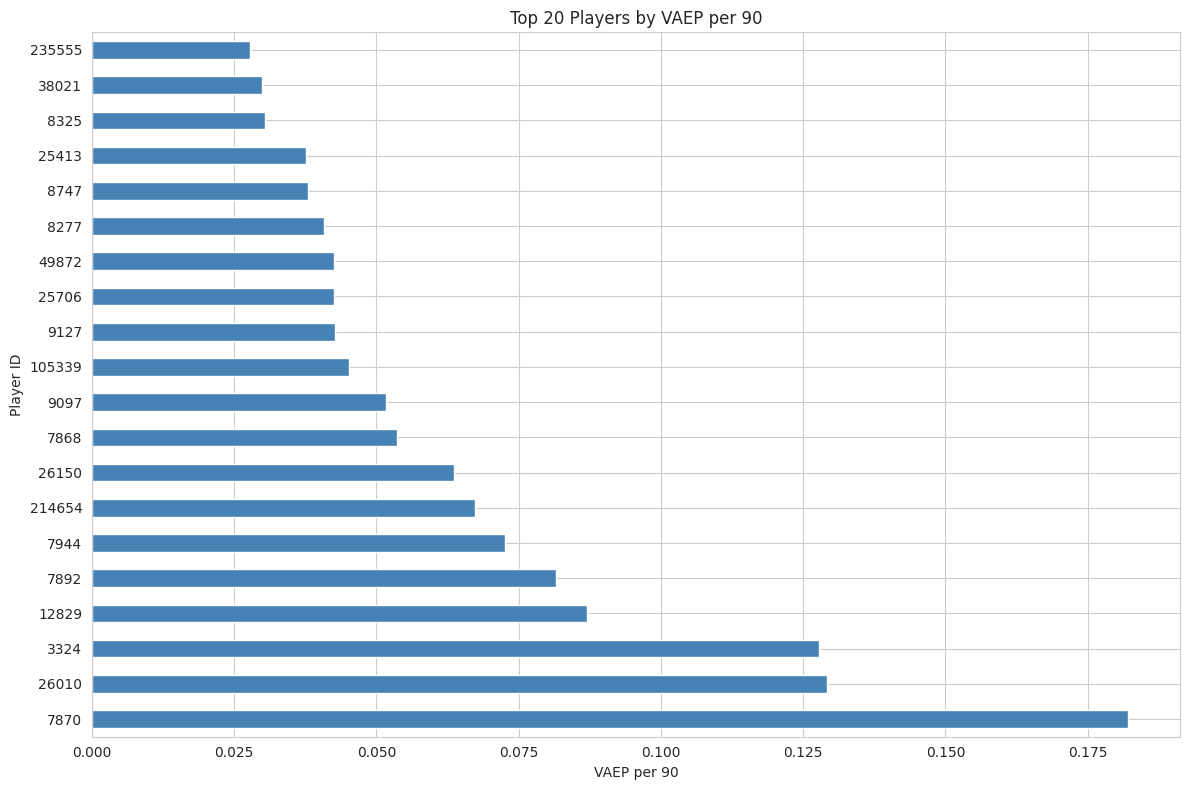

In [57]:
# TOP 20 선수 (VAEP per 90 기준)
top20_vaep_per90 = player_season_vaep.nlargest(20, 'season_vaep_per90_avg')[['playerId', 'season_vaep_per90_avg', 'season_vaep_per_match', 'season_vaep_total', 'matches_played', 'num_events']]

print("=" * 60)
print("TOP 20 Players by VAEP per 90")
print("=" * 60)
print(top20_vaep_per90.to_string(index=False))
print()

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
top20_vaep_per90.plot(x='playerId', y='season_vaep_per90_avg', kind='barh', ax=ax, legend=False, color='steelblue')
ax.set_xlabel('VAEP per 90')
ax.set_ylabel('Player ID')
ax.set_title('Top 20 Players by VAEP per 90')
plt.tight_layout()
plt.show()


## 비정상적으로 높은 VAEP 선수 탐지

- 경기 수가 1이거나, 이벤트 수가 매우 적은데 VAEP가 비정상적으로 높은 선수는 아래에서 확인할 수 있습니다.
- 이런 선수는 outlier로 간주할 수 있습니다.


In [ ]:
# 비정상적으로 높은 VAEP 선수 탐지
# 기준: 경기 수 1, 이벤트 수 10 이하, VAEP per 90 상위 10명
outlier_candidates = player_season_vaep[(player_season_vaep['matches_played'] == 1) & (player_season_vaep['num_events'] <= 10)]
outlier_candidates = outlier_candidates.sort_values('season_vaep_per90_avg', ascending=False)

print("경기 1회, 이벤트 10회 이하, VAEP per 90 상위 선수:")
print(outlier_candidates[['playerId', 'season_vaep_per90_avg', 'num_events', 'season_vaep_total']])

# 전체 상위 10명 VAEP per 90
print("\n전체 상위 10명 VAEP per 90:")
print(player_season_vaep.nlargest(10, 'season_vaep_per90_avg')[['playerId', 'season_vaep_per90_avg', 'matches_played', 'num_events', 'season_vaep_total']])


TOP 20 Players by Total VAEP
 playerId  season_vaep_total  season_vaep_per_match  season_vaep_per90_avg  matches_played  num_events
     7870           0.091061               0.091061               0.182122               1          22
    12829           0.086948               0.086948               0.086948               1          43
     7892           0.081632               0.081632               0.081632               1          83
     7944           0.072616               0.072616               0.072616               1          94
   214654           0.067372               0.067372               0.067372               1          65
    26010           0.064578               0.064578               0.129156               1          15
     3324           0.063878               0.063878               0.127757               1          23
    26150           0.063551               0.063551               0.063551               1          77
     7868           0.053570               0

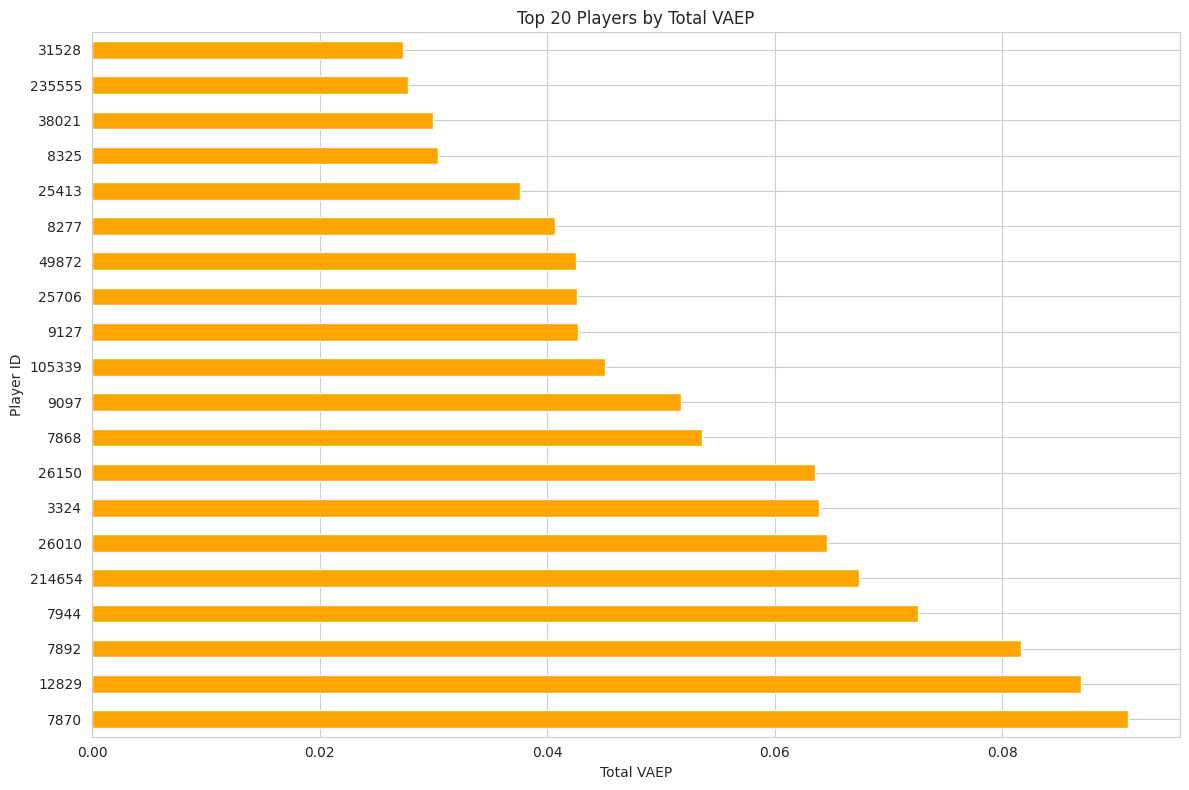

In [58]:
# TOP 20 선수 (총 VAEP 기준)
top20_total_vaep = player_season_vaep.nlargest(20, 'season_vaep_total')[['playerId', 'season_vaep_total', 'season_vaep_per_match', 'season_vaep_per90_avg', 'matches_played', 'num_events']]

print("=" * 60)
print("TOP 20 Players by Total VAEP")
print("=" * 60)
print(top20_total_vaep.to_string(index=False))
print()

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))
top20_total_vaep.plot(x='playerId', y='season_vaep_total', kind='barh', ax=ax, legend=False, color='orange')
ax.set_xlabel('Total VAEP')
ax.set_ylabel('Player ID')
ax.set_title('Top 20 Players by Total VAEP')
plt.tight_layout()
plt.show()


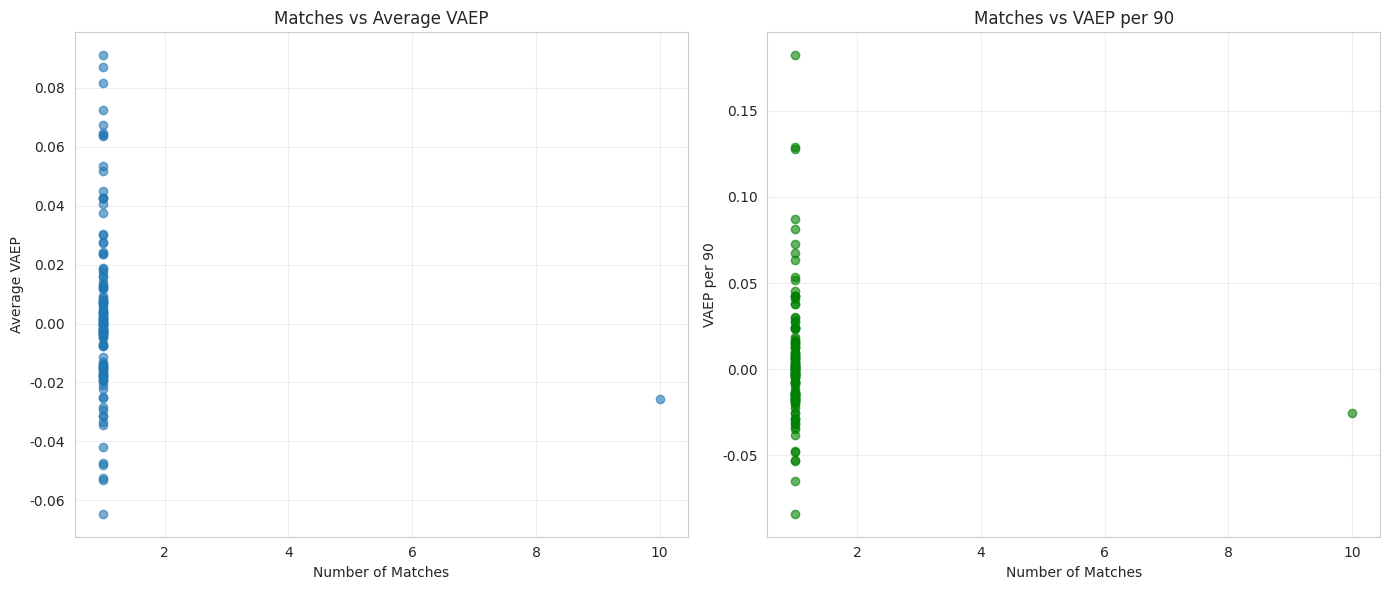

In [59]:
# 경기 수 vs VAEP 관계
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 경기 수 vs 평균 VAEP
axes[0].scatter(player_season_vaep['matches_played'], player_season_vaep['season_vaep_per_match'], alpha=0.6)
axes[0].set_xlabel('Number of Matches')
axes[0].set_ylabel('Average VAEP')
axes[0].set_title('Matches vs Average VAEP')
axes[0].grid(True, alpha=0.3)

# 경기 수 vs VAEP per 90
axes[1].scatter(player_season_vaep['matches_played'], player_season_vaep['season_vaep_per90_avg'], alpha=0.6, color='green')
axes[1].set_xlabel('Number of Matches')
axes[1].set_ylabel('VAEP per 90')
axes[1].set_title('Matches vs VAEP per 90')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


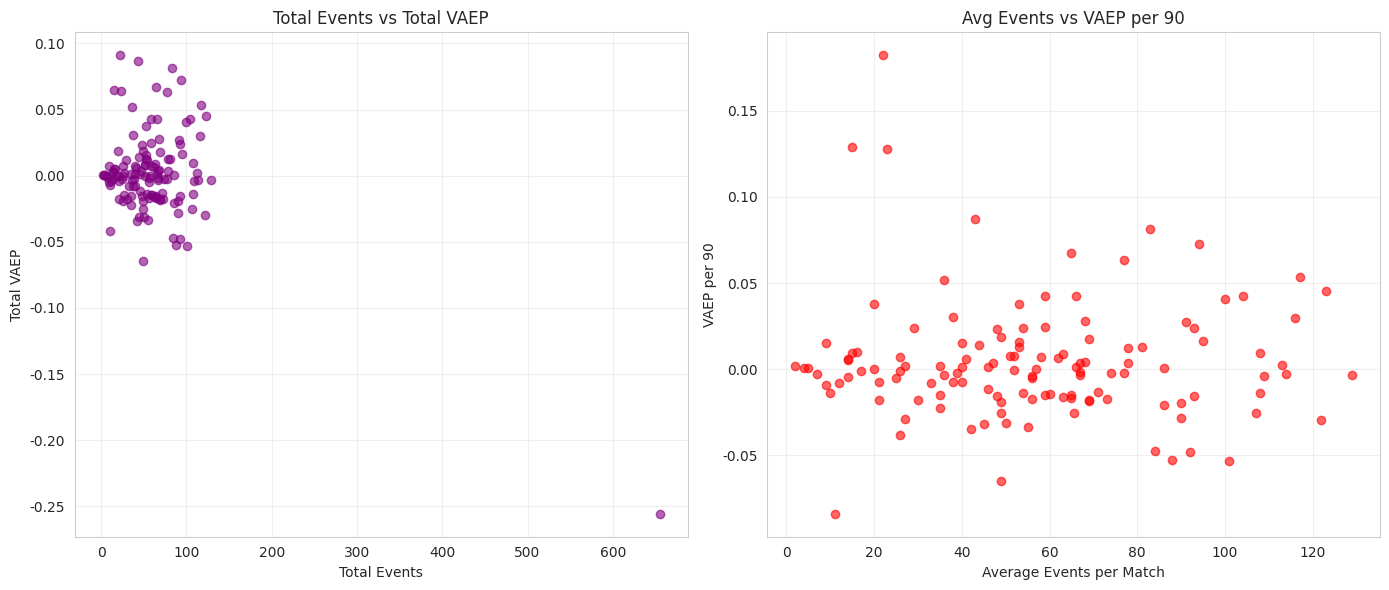

In [60]:
# 이벤트 수 vs VAEP 관계
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 총 이벤트 수 vs 총 VAEP
axes[0].scatter(player_season_vaep['num_events'], player_season_vaep['season_vaep_total'], alpha=0.6, color='purple')
axes[0].set_xlabel('Total Events')
axes[0].set_ylabel('Total VAEP')
axes[0].set_title('Total Events vs Total VAEP')
axes[0].grid(True, alpha=0.3)

# 평균 이벤트 수 vs VAEP per 90
player_season_vaep['avg_events_per_match'] = player_season_vaep['num_events'] / player_season_vaep['matches_played']
axes[1].scatter(player_season_vaep['avg_events_per_match'], player_season_vaep['season_vaep_per90_avg'], alpha=0.6, color='red')
axes[1].set_xlabel('Average Events per Match')
axes[1].set_ylabel('VAEP per 90')
axes[1].set_title('Avg Events vs VAEP per 90')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. 데이터 품질 검증

In [61]:
# 결측치 확인
print("=" * 60)
print("결측치 확인 (학습 데이터)")
print("=" * 60)
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])
if missing_train.sum() == 0:
    print("결측치 없음 ✓")
print()

print("=" * 60)
print("결측치 확인 (평가 데이터)")
print("=" * 60)
missing_eval = eval_df.isnull().sum()
print(missing_eval[missing_eval > 0])
if missing_eval.sum() == 0:
    print("결측치 없음 ✓")
print()

결측치 확인 (학습 데이터)
subEventId      136
subEventName    136
dtype: int64

결측치 확인 (평가 데이터)
subEventId      28
subEventName    28
dtype: int64



In [62]:
# 이상치 확인
print("=" * 60)
print("이상치 확인")
print("=" * 60)

# 위치 좌표 범위 확인 (0-1 정규화되어야 함)
position_cols = ['start_x', 'start_y', 'end_x', 'end_y']
for col in position_cols:
    min_val = train_df[col].min()
    max_val = train_df[col].max()
    print(f"{col}: [{min_val:.3f}, {max_val:.3f}]")
    if min_val < 0 or max_val > 1:
        print(f"  ⚠️ 경고: {col} 값이 [0, 1] 범위를 벗어남")
print()

# 성공 여부 값 확인
success_values = train_df['is_successful'].unique()
print(f"is_successful 고유값: {success_values}")
if not all(v in [0, 1] for v in success_values):
    print("  ⚠️ 경고: is_successful가 0 또는 1이 아닌 값을 포함")
print()

# 골 여부 값 확인
goal_values = train_df['is_goal'].unique()
print(f"is_goal 고유값: {goal_values}")
if not all(v in [0, 1] for v in goal_values):
    print("  ⚠️ 경고: is_goal이 0 또는 1이 아닌 값을 포함")
print()

이상치 확인
start_x: [0.000, 1.000]
start_y: [0.000, 1.000]
end_x: [0.000, 1.000]
end_y: [0.000, 1.000]

is_successful 고유값: [1 0]

is_goal 고유값: [0 1]



In [63]:
# VAEP 값 범위 확인
print("=" * 60)
print("VAEP 값 범위 확인")
print("=" * 60)
print(f"VAEP 최소값: {player_match_vaep['vaep'].min():.6f}")
print(f"VAEP 최대값: {player_match_vaep['vaep'].max():.6f}")
print(f"VAEP 평균: {player_match_vaep['vaep'].mean():.6f}")
print(f"VAEP 중앙값: {player_match_vaep['vaep'].median():.6f}")
print(f"VAEP 표준편차: {player_match_vaep['vaep'].std():.6f}")
print()

print(f"VAEP per 90 최소값: {player_match_vaep['vaep_per90'].min():.6f}")
print(f"VAEP per 90 최대값: {player_match_vaep['vaep_per90'].max():.6f}")
print(f"VAEP per 90 평균: {player_match_vaep['vaep_per90'].mean():.6f}")
print(f"VAEP per 90 중앙값: {player_match_vaep['vaep_per90'].median():.6f}")
print(f"VAEP per 90 표준편차: {player_match_vaep['vaep_per90'].std():.6f}")
print()

VAEP 값 범위 확인
VAEP 최소값: -0.094678
VAEP 최대값: 0.091061
VAEP 평균: 0.001001
VAEP 중앙값: -0.000932
VAEP 표준편차: 0.028830

VAEP per 90 최소값: -0.094678
VAEP per 90 최대값: 0.182122
VAEP per 90 평균: 0.002401
VAEP per 90 중앙값: -0.001428
VAEP per 90 표준편차: 0.035590



## 6. 최종 검증 요약

In [64]:
print("=" * 80)
print(" " * 30 + "최종 검증 요약")
print("=" * 80)
print()

print("✓ 데이터 전처리")
print(f"  - 학습 이벤트: {len(train_df):,}")
print(f"  - 평가 이벤트: {len(eval_df):,}")
print(f"  - 리그: {len(train_df['league'].unique())}개")
print()

print("✓ 피처 인코딩")
print(f"  - 이벤트 타입: {len(event_features)}개")
print(f"  - 서브이벤트 타입: {len(subevent_features)}개")
print(f"  - 태그: {len(tag_features)}개 (지정된 55개 중 {len(used_expected_tags)}개 사용)")
print(f"  - 기타 피처: {len(position_features) + len(goal_features) + len(movement_features) + len(success_features) + len(period_features)}개")
print(f"  - 총 피처 차원: {model_config['input_dim']}개")
print()

print("✓ 모델 학습")
print(f"  - 입력 차원: {model_config['input_dim']}")
print(f"  - 은닉층: {model_config['hidden_dims']}")
print(f"  - Best Validation Loss: {model_config['best_val_loss']:.6f}")
print()

print("✓ 선수 VAEP 결과")
print(f"  - 경기별 레코드: {len(player_match_vaep):,}개")
print(f"  - 시즌 선수 수: {len(player_season_vaep)}명")
print(f"  - 평균 VAEP per 90: {player_season_vaep['season_vaep_per90_avg'].mean():.6f}")
print(f"  - TOP 1 VAEP per 90: {player_season_vaep['season_vaep_per90_avg'].max():.6f} (Player {player_season_vaep.loc[player_season_vaep['season_vaep_per90_avg'].idxmax(), 'playerId']})")
print()

print("✓ 데이터 품질")
print(f"  - 결측치: {'없음 ✓' if missing_train.sum() == 0 and missing_eval.sum() == 0 else '있음 ⚠️'}")
print(f"  - 위치 좌표: [0, 1] 범위 {'준수 ✓' if train_df[position_cols].min().min() >= 0 and train_df[position_cols].max().max() <= 1 else '위반 ⚠️'}")
print(f"  - 이진 변수: {'정상 ✓' if all(v in [0, 1] for v in train_df['is_successful'].unique()) else '이상 ⚠️'}")
print()

print("=" * 80)
print(" " * 25 + "검증 완료! All checks passed ✓")
print("=" * 80)


                              최종 검증 요약

✓ 데이터 전처리
  - 학습 이벤트: 47,964
  - 평가 이벤트: 8,101
  - 리그: 6개

✓ 피처 인코딩
  - 이벤트 타입: 10개
  - 서브이벤트 타입: 29개
  - 태그: 55개 (지정된 55개 중 53개 사용)
  - 기타 피처: 11개
  - 총 피처 차원: 105개

✓ 모델 학습
  - 입력 차원: 105
  - 은닉층: [128, 64]
  - Best Validation Loss: 0.166987

✓ 선수 VAEP 결과
  - 경기별 레코드: 136개
  - 시즌 선수 수: 127명
  - 평균 VAEP per 90: 0.004383
  - TOP 1 VAEP per 90: 0.182122 (Player 7870)

✓ 데이터 품질
  - 결측치: 있음 ⚠️
  - 위치 좌표: [0, 1] 범위 준수 ✓
  - 이진 변수: 정상 ✓

                         검증 완료! All checks passed ✓
